# 在 VTA 上部署预训练的 Darknet 视觉检测模型

**原作者**: [Hua Jiang](https://github.com/huajsj)

本教程提供了端到端 demo，关于如何在 VTA 加速器设计上运行 Darknet YoloV3-tiny inference 来执行图像检测任务。它展示了 Relay 作为前端编译器，它可以执行量化（VTA 只支持 int8/32 推理）和 graph packing（为了在 core 中支持张量），从而为硬件目标 massage 计算图（compute graph）。

## 安装依赖

要在 `tvm` 中使用 `autotvm` 包，需要安装一些额外的依赖项。（如果你使用 python2，将 "3" 改为 "2"）：

```bash
pip3 install "Pillow<7"
```

带有 Darknet 解析的 YOLO-V3-tiny Model 依赖于 CFFI 和 CV2 库，需要在执行此脚本前安装 CFFI 和 CV2。

```bash
pip3 install cffi
pip3 install opencv-python
```

现在返回 python 代码。导入包。

In [1]:
import sys
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import tvm
import vta
from tvm import rpc, autotvm, relay
from tvm.relay.testing import yolo_detection, darknet
from tvm.relay.testing.darknet import __darknetffi__
from tvm.contrib import graph_executor, utils
from tvm.contrib.download import download_testdata
from vta.testing import simulator
from vta.top import graph_pack

# Make sure that TVM was compiled with RPC=1
assert tvm.runtime.enabled("rpc")

根据 Model 名称 下载 yolo net 配置文件，权重文件，darknet 库文件：

In [2]:
MODEL_NAME = "yolov3-tiny"
REPO_URL = "https://github.com/dmlc/web-data/blob/main/darknet/"

cfg_path = download_testdata(
    "https://github.com/pjreddie/darknet/blob/master/cfg/" + MODEL_NAME + ".cfg" + "?raw=true",
    MODEL_NAME + ".cfg",
    module="darknet",
)
weights_path = download_testdata(
    "https://pjreddie.com/media/files/" + MODEL_NAME + ".weights" + "?raw=true",
    MODEL_NAME + ".weights",
    module="darknet",
)

if sys.platform in ["linux", "linux2"]:
    darknet_lib_path = download_testdata(
        REPO_URL + "lib/" + "libdarknet2.0.so" + "?raw=true", "libdarknet2.0.so", module="darknet"
    )
elif sys.platform == "darwin":
    darknet_lib_path = download_testdata(
        REPO_URL + "lib_osx/" + "libdarknet_mac2.0.so" + "?raw=true",
        "libdarknet_mac2.0.so",
        module="darknet",
    )
else:
    raise NotImplementedError("Darknet lib is not supported on {} platform".format(sys.platform))

下载 yolo 类别和 illustration 前端：

In [3]:
coco_path = download_testdata(
    REPO_URL + "data/" + "coco.names" + "?raw=true", "coco.names", module="data"
)
font_path = download_testdata(
    REPO_URL + "data/" + "arial.ttf" + "?raw=true", "arial.ttf", module="data"
)
with open(coco_path) as f:
    content = f.readlines()
names = [x.strip() for x in content]

## 定义平台和模型目标

在 CPU 和VTA 上执行，并定义模型。

In [4]:
# Load VTA parameters from the 3rdparty/vta-hw/config/vta_config.json file
env = vta.get_env()
# Set ``device=arm_cpu`` to run inference on the CPU
# or ``device=vta`` to run inference on the FPGA.
device = "vta"
target = env.target if device == "vta" else env.target_vta_cpu

pack_dict = {
    "yolov3-tiny": ["nn.max_pool2d", "cast", 4, 186],
}

# Name of Darknet model to compile
# The ``start_pack`` and ``stop_pack`` labels indicate where
# to start and end the graph packing relay pass: in other words
# where to start and finish offloading to VTA.
# the number 4 indicate the the ``start_pack`` index is 4, the
# number 186 indicate the ``stop_pack index`` is 186, by using
# name and index number, here we can located to correct place
# where to start/end when there are multiple ``nn.max_pool2d``
# or ``cast``, print(mod.astext(show_meta_data=False)) can help
# to find operator name and index information.
assert MODEL_NAME in pack_dict

## 获取执行远程

当 target 为 'pynq' 或其他 FPGA 后端时，重新配置 FPGA 和运行时。否则，如果 target 为 'sim'，则在本地执行。

In [5]:
if env.TARGET not in ["sim", "tsim"]:
    # Get remote from tracker node if environment variable is set.
    # To set up the tracker, you'll need to follow the "Auto-tuning
    # a convolutional network for VTA" tutorial.
    tracker_host = os.environ.get("TVM_TRACKER_HOST", None)
    tracker_port = os.environ.get("TVM_TRACKER_PORT", None)
    # Otherwise if you have a device you want to program directly from
    # the host, make sure you've set the variables below to the IP of
    # your board.
    device_host = os.environ.get("VTA_RPC_HOST", "192.168.2.99")
    device_port = os.environ.get("VTA_RPC_PORT", "9091")
    if not tracker_host or not tracker_port:
        remote = rpc.connect(device_host, int(device_port))
    else:
        remote = autotvm.measure.request_remote(
            env.TARGET, tracker_host, int(tracker_port), timeout=10000
        )
    # Reconfigure the JIT runtime and FPGA.
    # You can program the FPGA with your own custom bitstream
    # by passing the path to the bitstream file instead of None.
    reconfig_start = time.time()
    vta.reconfig_runtime(remote)
    vta.program_fpga(remote, bitstream=None)
    reconfig_time = time.time() - reconfig_start
    print("Reconfigured FPGA and RPC runtime in {0:.2f}s!".format(reconfig_time))

# In simulation mode, host the RPC server locally.
else:
    remote = rpc.LocalSession()

# Get execution context from remote
ctx = remote.ext_dev(0) if device == "vta" else remote.cpu(0)

## 构建推理 graph executor

利用 Darknet 库加载下载视觉模型，并用 Relay 编译。编译步骤如下：

1. 从 Darknet 到 Relay 模块的前端翻译。
2. 应用 8 位量化：这里跳过第一个 conv 层和 dense 层，它们都将在 CPU 上的 fp32 中执行。
3. 执行 graph packing 以更改数据布局以进行张量化。
4. 执行常量折叠以减少算子的数量（例如，消除 batch norm 乘法）。
5. 执行 Relay 构建 object 文件。
6. 将 object 文件加载到远程（FPGA 设备）。
7. 生成 graph executor `m`。

In [6]:
# Load pre-configured AutoTVM schedules
with autotvm.tophub.context(target):
    net = __darknetffi__.dlopen(darknet_lib_path).load_network(
        cfg_path.encode("utf-8"), weights_path.encode("utf-8"), 0
    )
    dshape = (env.BATCH, net.c, net.h, net.w)
    dtype = "float32"

    # Measure build start time
    build_start = time.time()

    # Start front end compilation
    mod, params = relay.frontend.from_darknet(net, dtype=dtype, shape=dshape)

    if target.device_name == "vta":
        # Perform quantization in Relay
        # Note: We set opt_level to 3 in order to fold batch norm
        with tvm.transform.PassContext(opt_level=3):
            with relay.quantize.qconfig(
                global_scale=23.0,
                skip_conv_layers=[0],
                store_lowbit_output=True,
                round_for_shift=True,
            ):
                mod = relay.quantize.quantize(mod, params=params)
            # Perform graph packing and constant folding for VTA target
            mod = graph_pack(
                mod["main"],
                env.BATCH,
                env.BLOCK_OUT,
                env.WGT_WIDTH,
                start_name=pack_dict[MODEL_NAME][0],
                stop_name=pack_dict[MODEL_NAME][1],
                start_name_idx=pack_dict[MODEL_NAME][2],
                stop_name_idx=pack_dict[MODEL_NAME][3],
            )
    else:
        mod = mod["main"]

    # Compile Relay program with AlterOpLayout disabled
    with vta.build_config(disabled_pass={"AlterOpLayout", "tir.CommonSubexprElimTIR"}):
        lib = relay.build(
            mod, target=tvm.target.Target(target, host=env.target_host), params=params
        )

    # Measure Relay build time
    build_time = time.time() - build_start
    print(MODEL_NAME + " inference graph built in {0:.2f}s!".format(build_time))

    # Send the inference library over to the remote RPC server
    temp = utils.tempdir()
    lib.export_library(temp.relpath("graphlib.tar"))
    remote.upload(temp.relpath("graphlib.tar"))
    lib = remote.load_module("graphlib.tar")

    # Graph executor
    m = graph_executor.GraphModule(lib["default"](ctx))

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.
[21:26:43] /media/pc/data/lxw/ai/tvm/src/tir/transforms/arg_binder.cc:95: Warning: Trying to bind buffer to another one with lower alignment requirement  required_alignment=256, provided_alignment=64
[21:26:43] /media/pc/data/lxw/ai/tvm/src/tir/transforms/arg_binder.cc:95: Warning: Trying to bind buffer to another one with lower alignment requirement  required_alignment=256, provided_alignment=64
[21:26:43] /media/pc/data/lxw/ai/tvm/src/tir/transforms/arg_binder.cc:95: Warning: Trying to bind buffer to another one with lower alignment requirement  required_alignment=256, provided_alignment=64
[21:26:44] /media/pc/data/lxw/ai/tvm/src/tir/transforms/arg_binder.cc:95: Warning: Trying to bind buffer to another one with lower alignment requirement  required_alignment=256, provided_alignment=64
[21:26:44] /media/pc/data/lxw/ai/tvm/src/tir/transforms/arg_binde

yolov3-tiny inference graph built in 46.92s!


2023-04-10 21:26:49.379 INFO load_module /tmp/tmpalwog1_0/graphlib.tar


## 执行图像检测推理

检测已下载的图像：

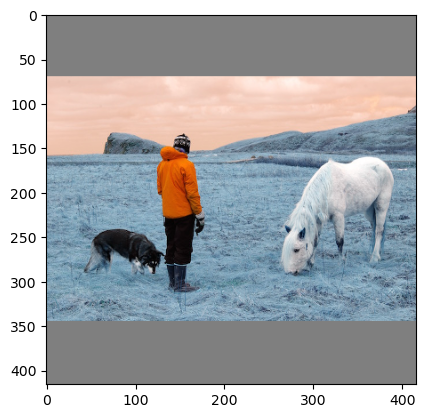

[21:26:56] /media/pc/data/lxw/ai/tvm/src/runtime/profiling.cc:101: Warning: No timer implementation for ext_dev, using default timer instead. It may be inaccurate or have extra overhead.



Execution statistics:
	inp_load_nbytes :         25462784
	wgt_load_nbytes :         17558016
	acc_load_nbytes :            96128
	uop_load_nbytes :             5024
	out_store_nbytes:          3396224
	gemm_counter    :         10578048
	alu_counter     :           849056


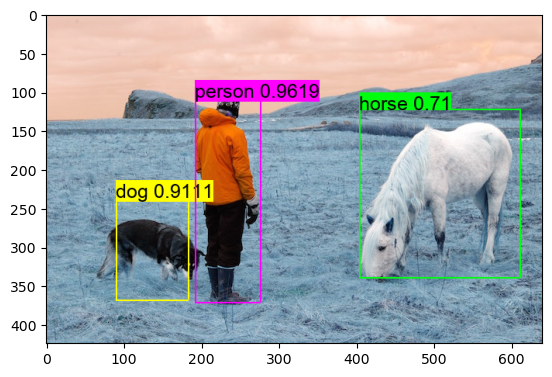

In [7]:
[neth, netw] = dshape[2:]
test_image = "person.jpg"
img_url = REPO_URL + "data/" + test_image + "?raw=true"
img_path = download_testdata(img_url, test_image, "data")
data = darknet.load_image(img_path, neth, netw).transpose(1, 2, 0)

# Prepare test image for inference
plt.imshow(data)
plt.show()
data = data.transpose((2, 0, 1))
data = data[np.newaxis, :]
data = np.repeat(data, env.BATCH, axis=0)

# Set the network parameters and inputs
m.set_input("data", data)

# Perform inference and gather execution statistics
# More on: :py:method:`tvm.runtime.Module.time_evaluator`
num = 4  # number of times we run module for a single measurement
rep = 3  # number of measurements (we derive std dev from this)
timer = m.module.time_evaluator("run", ctx, number=num, repeat=rep)

if env.TARGET in ["sim", "tsim"]:
    simulator.clear_stats()
    timer()
    sim_stats = simulator.stats()
    print("\nExecution statistics:")
    for k, v in sim_stats.items():
        # Since we execute the workload many times, we need to normalize stats
        # Note that there is always one warm up run
        # Therefore we divide the overall stats by (num * rep + 1)
        print("\t{:<16}: {:>16}".format(k, v // (num * rep + 1)))
else:
    tcost = timer()
    std = np.std(tcost.results) * 1000
    mean = tcost.mean * 1000
    print("\nPerformed inference in %.2fms (std = %.2f) for %d samples" % (mean, std, env.BATCH))
    print("Average per sample inference time: %.2fms" % (mean / env.BATCH))

# Get detection results from out
thresh = 0.5
nms_thresh = 0.45
tvm_out = []
for i in range(2):
    layer_out = {}
    layer_out["type"] = "Yolo"
    # Get the yolo layer attributes (n, out_c, out_h, out_w, classes, total)
    layer_attr = m.get_output(i * 4 + 3).numpy()
    layer_out["biases"] = m.get_output(i * 4 + 2).numpy()
    layer_out["mask"] = m.get_output(i * 4 + 1).numpy()
    out_shape = (layer_attr[0], layer_attr[1] // layer_attr[0], layer_attr[2], layer_attr[3])
    layer_out["output"] = m.get_output(i * 4).numpy().reshape(out_shape)
    layer_out["classes"] = layer_attr[4]
    tvm_out.append(layer_out)
    thresh = 0.560

# Show detection results
img = darknet.load_image_color(img_path)
_, im_h, im_w = img.shape
dets = yolo_detection.fill_network_boxes((netw, neth), (im_w, im_h), thresh, 1, tvm_out)
last_layer = net.layers[net.n - 1]
yolo_detection.do_nms_sort(dets, last_layer.classes, nms_thresh)
yolo_detection.draw_detections(font_path, img, dets, thresh, names, last_layer.classes)
plt.imshow(img.transpose(1, 2, 0))
plt.show()